In [6]:
import sys
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.pylab as pl
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=19)
leg_prop = font_manager.FontProperties(fname=font_path, size=17)
def plot_iter(filedir,num_iter,num_walkers,cv_index,time_len):
    colors = pl.cm.jet(np.linspace(0,1,num_walkers))
    fig, ax = plt.subplots(figsize=(6,4))
    for wal in range(5,6):
        walker_name='%03d' %wal
        for it in range(int(num_iter)):
            iteration="%06d" %it
            filename=filedir+"iter."+str(iteration)+"/00.enhcMD/"+str(walker_name)+"/plm.out"
            data = np.loadtxt(filename)
            time = data[:,0]+it*float(time_len)
            ang = data[:,int(cv_index)]
            if np.max(ang)>4:
                print(filename)
            ax.plot(time,ang,alpha=0.8,color=colors[wal])
    ax.set_ylabel('distance (nm)',fontproperties=font_prop)
    ax.set_xlabel('time (ps)',fontproperties=font_prop)
    #plt.ylim(-3.2,3.2)
    #plt.xlim(0,np.max(time))
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(16)
    #plt.savefig(figout,dpi=600,bbox_inches='tight')
    plt.show()


/home/dongdong/SCR/ykt6.run07/iter.000002/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000003/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000004/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000005/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000009/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000010/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000011/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000012/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000013/00.enhcMD/005/plm.out
/home/dongdong/SCR/ykt6.run07/iter.000014/00.enhcMD/005/plm.out


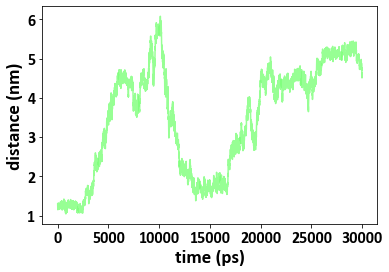

In [7]:
plot_iter('/home/dongdong/SCR/ykt6.run07/',15,11,8,2000)

In [11]:
import re
import os
import sys
import argparse
import numpy as np
import tensorflow as tf

kbT = (8.617343E-5) * 300
beta = 1.0 / kbT
f_cvt = 96.485
cv_dim = 11

def load_graph(frozen_graph_filename,
               prefix = 'load'):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we can use again a convenient built-in function to import a graph_def into the 
    # current default Graph
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
            graph_def,
            input_map=None,
            return_elements=None,
            name=prefix,
            op_dict=None,
            producer_op_list=None
        )
    return graph

def test_ef (sess, xx) :
    graph = sess.graph

    inputs  = graph.get_tensor_by_name ('load/inputs:0')
    o_energy= graph.get_tensor_by_name ('load/o_energy:0')
    o_forces= graph.get_tensor_by_name ('load/o_forces:0')

    zero4 = np.zeros ([xx.shape[0], cv_dim])
    data_inputs = np.concatenate ((xx, zero4), axis = 1)
    feed_dict_test = {inputs: data_inputs}

    data_ret = sess.run ([o_energy, o_forces], feed_dict = feed_dict_test)
    return data_ret[0], data_ret[1]


In [15]:
import glob
dirname='/home/dongdong/SCR/ykt6.run07'
ave_ene=[]
for it in range(0,15):
    for en in range(5,6):
        trjdir='%s/iter.%06d/00.enhcMD/%03d/' %(dirname,it,en)
        models = glob.glob('/home/dongdong/SCR/ykt6.run07/iter.000014/00.enhcMD/000/*.pb')
        data_ = np.loadtxt (trjdir+'angle.rad.out')
        data = data_[:,:cv_dim]
        nframes = data.shape[0]
        energys = []
        for ii in models :
            graph = load_graph (ii)
            with tf.Session(graph = graph) as sess:
                ee, ff = test_ef (sess, data)
                #forces = np.append (forces, ff)
                energys = np.append (energys, ee)
                # if len(forces) == 0 :
                #     forces = np.array ([ff])
                # else :
                #     forces = np.concatenate (forces, np.array([ff]))
        #forces = np.reshape (forces, [len(models), nframes, cv_dim])
        energys = np.reshape (energys, [len(models), nframes])

    ave_ene=np.append(ave_ene,-np.mean(energys,axis=0))
print(ave_ene)
print(len(ave_ene))

[ 1.39103215  1.374764    1.44369261 ... -0.72189438 -0.73905086
 -0.71465672]
7515


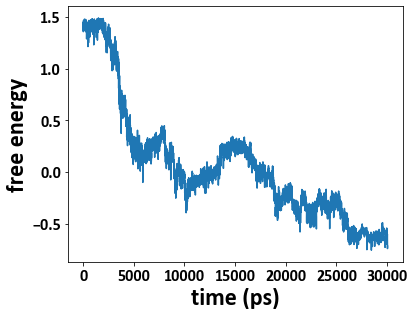

In [18]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=24)
leg_prop = font_manager.FontProperties(fname=font_path, size=17)

time = np.arange(len(ave_ene))*0.004*1000
#for i in range(len(clustered_trajs)):

fig, ax = plt.subplots(figsize=(6,4.7))
ax.plot(time,ave_ene)
ax.set_ylabel(r'free energy',fontproperties=font_prop)
ax.set_xlabel('time (ps)',fontproperties=font_prop)
#plt.ylim(0,0.5)
#plt.xlim(0,180)
#leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
#leg.get_frame().set_linewidth(0.0)
#leg.get_frame().set_alpha(0.1)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.show()

In [2]:
cd /home/dongdong/SCR/ykt6.run07

/scratch/gpfs/dongdong/ykt6.run07


In [3]:
import os
for it in range(20):
    for en in range(12):
        #print(en)
        trjdir='/home/dongdong/SCR/ykt6.run07/iter.%06d/00.enhcMD/%03d/' %(it,en)
        
        trjname=trjdir+'traj_comp.xtc'
        outtrj=trjdir+'md_nopbc.xtc'
        outfit=trjdir+str(en)+'_fit'+str(it)+'.xtc'
        outrmsd=trjdir+'rmsd.xvg'
        #print(trjname)
        os.system('echo -e "1\n" | gmx trjconv -s nosol.tpr -f %s -o %s -pbc mol -ur compact' %(trjname, outtrj))
        os.system('echo -e "1\n1\n" | gmx trjconv -s nosol.tpr -f %s -o %s -fit rot+trans' %(outtrj, outfit))